In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv("nlp_train.csv", encoding = "ISO-8859-1")

### Number of comments in each category

In [9]:
df_train = df.drop(['body'], axis=1)
counts = []
categories = list(df_train.columns.values)
for i in categories:
    counts.append((i, df_train[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,anger,544
1,anticipation,751
2,disgust,678
3,fear,678
4,joy,185
5,love,138
6,optimism,490
7,pessimism,646
8,sadness,414
9,surprise,162


Text(0.5, 0, 'category')

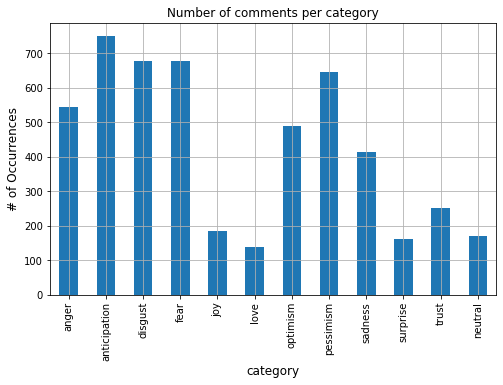

In [10]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

### Multi-Label

How many comments have multiple labels?

Text(0.5, 0, '# of categories')

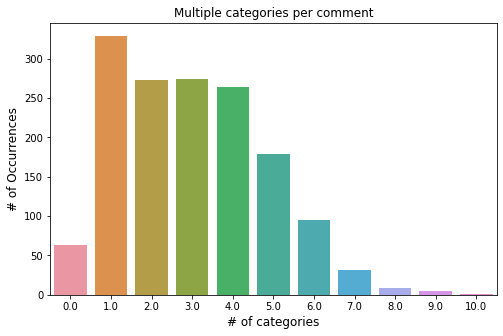

In [11]:
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

Vast majority of the comment texts are not labeled.

The distribution of the number of words in comment texts.

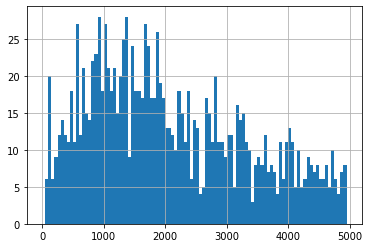

In [14]:
lens = df.body.str.len()
lens.hist(bins = np.arange(0,5000,50))

Most of the comment text length are within 500 characters, with some outliers up to 5,000 characters long.

In [17]:
print('Percentage of comments that are not labelled:')
print(len(df[(df['anger']==0) & (df['anticipation']==0) & (df['disgust']==0) & (df['fear']== 0) & (df['joy']==0) & (df['love']==0) & (df['optimism']==0) & (df['pessimism']==0) & (df['sadness']==0) & (df['surprise']==0) & (df['trust']==0) & (df['neutral']==0)]) / len(df))

Percentage of comments that are not labelled:
0.01772816808929744


There is no missing comment in comment text column.

In [16]:
print('Number of missing comments in comment text:')
df['body'].isnull().sum()

Number of missing comments in comment text:


0

Have a peek the first comment, the text needs clean.

In [15]:
df['body'][0]

'He was answering a question about the criticism by the same individual s that were referring to it as The Chinese and Wuhan Corona Virus last week. But I guess blind hatred negates the ability to look at things objectively. Is he a jackass? Yes but this constant negativity from the moment he was nominated is exhausting.'

In [0]:
categories = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love','optimism', 'pessimism', 'sadness', 'surprise', 'trust', 'neutral]

### Create a function to clean the text

In [0]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

### Clean up comment_text column 

In [0]:
df['body'] = df['body'].map(lambda com : clean_text(com))

Much better!

In [20]:
df['body'][0]

'he was answering a question about the criticism by the same individual s that were referring to it as the chinese and wuhan corona virus last week but i guess blind hatred negates the ability to look at things objectively is he a jackass yes but this constant negativity from the moment he was nominated is exhausting'

### Split to train and test sets

In [0]:
#train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)
train = pd.read_csv("nlp_train.csv", encoding = "ISO-8859-1")
test = pd.read_csv("nlp_test.csv", encoding = "ISO-8859-1")
train = train.dropna()
test = test.dropna()

In [31]:
X_train = train.body
X_test = test.body
train.replace(True, 1, inplace=True)
train.replace(False, 0, inplace=True)
test.replace(True, 1, inplace=True)
test.replace(False, 0, inplace=True)
print(X_train.shape)
print(X_test.shape)

(1493,)
(374,)


### Pipeline

scikit-learn provides a Pipeline utility to help automate machine learning workflows. Pipelines are very common in Machine Learning systems, since there is a lot of data to manipulate and many data transformations to apply. So we will utilize pipeline to train every classifier.

### OneVsRest multilabel strategy

The Multi-label algorithm accepts a binary mask over multiple labels. The result for each prediction will be an array of 0s and 1s marking which class labels apply to each row input sample.

### Naive Bayes

OneVsRest strategy can be used for multilabel learning, where a classifier is used to predict multiple labels for instance. Naive Bayes supports multi-class, but we are in a multi-label scenario, therefore, we wrapp Naive Bayes in the OneVsRestClassifier.

In [0]:
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

In [33]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing anger
Test accuracy is 0.6951871657754011
... Processing anticipation
Test accuracy is 0.6042780748663101
... Processing disgust
Test accuracy is 0.7540106951871658
... Processing fear
Test accuracy is 0.6871657754010695
... Processing joy
Test accuracy is 0.8128342245989305
... Processing love
Test accuracy is 0.9197860962566845
... Processing optimism
Test accuracy is 0.7406417112299465
... Processing pessimism
Test accuracy is 0.6978609625668449
... Processing sadness
Test accuracy is 0.6363636363636364
... Processing surprise
Test accuracy is 0.8689839572192514
... Processing trust
Test accuracy is 0.839572192513369
... Processing neutral
Test accuracy is 0.8983957219251337


### LinearSVC

In [0]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])

In [35]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing anger
Test accuracy is 0.7459893048128342
... Processing anticipation
Test accuracy is 0.6283422459893048
... Processing disgust
Test accuracy is 0.7219251336898396
... Processing fear
Test accuracy is 0.6764705882352942
... Processing joy
Test accuracy is 0.820855614973262
... Processing love
Test accuracy is 0.9197860962566845
... Processing optimism
Test accuracy is 0.7032085561497327
... Processing pessimism
Test accuracy is 0.679144385026738
... Processing sadness
Test accuracy is 0.6631016042780749
... Processing surprise
Test accuracy is 0.8743315508021391
... Processing trust
Test accuracy is 0.8502673796791443
... Processing neutral
Test accuracy is 0.8903743315508021


### Logistic Regression

In [36]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing anger
Test accuracy is 0.767379679144385
... Processing anticipation
Test accuracy is 0.6470588235294118
... Processing disgust
Test accuracy is 0.732620320855615
... Processing fear
Test accuracy is 0.6871657754010695
... Processing joy
Test accuracy is 0.8128342245989305
... Processing love
Test accuracy is 0.9197860962566845
... Processing optimism
Test accuracy is 0.7459893048128342
... Processing pessimism
Test accuracy is 0.7299465240641712
... Processing sadness
Test accuracy is 0.660427807486631
... Processing surprise
Test accuracy is 0.8743315508021391
... Processing trust
Test accuracy is 0.8475935828877005
... Processing neutral
Test accuracy is 0.8983957219251337
